# Week 2: Diving deeper into the BBC News archive

Welcome! In this assignment you will be revisiting the [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which contains 2225 examples of news articles with their respective labels. 

This time you will not only work with the tokenization process but you will also create a classifier using specialized layers for text data such as Embedding and GlobalAveragePooling1D.

Let's get started!

In [107]:
# grader-required-cell

import random
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string 
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

You probably remember structure of the csv that contains the data from last week, but in case you need a reminder run the next cell:

In [4]:
with open("Dataset_Capstone_Clean.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

Text,Mood

Each data point looks like this:

i did there was a mental debate i can eat the food at home for dinner or i might look a bit pretentious when i help the poor kid or the kid might reject and ask for money id feel slighted and annoyed,anger



In [5]:
df = pd.read_csv('Dataset_Capstone_Clean.csv')
df.Mood.value_counts()

Mood
anger      5000
fear       5000
happy      5000
joy        5000
love       5000
neutral    5000
sadness    5000
worry      5000
Name: count, dtype: int64

As you can see, each data point is composed of the category of the news article followed by a comma and then the actual text of the article.

## Defining useful global variables

Next, you will define some global variables that will be used in the unit tests after your solutions. **Please do not use these in the function body of the graded functions.**

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Defaults to 1000.


- `EMBEDDING_DIM`: Dimensionality of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.


- `MAXLEN`: Maximum length of all sequences. Defaults to 120.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8

**For now leave them unchanged but after submitting your assignment for grading you are encouraged to come back here and play with these parameters to see the impact they have in the classification process**

In [6]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Loading and pre-processing the data

Now you should code the functions to remove stopwords from text and to load the data from a csv file.

Since you already coded these functions for the previous week, these are provided for you.

In [10]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "hed", "hell", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "it's", "its", "itself", "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "shell", "shes", "should", "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "there", "theres", "these", "they", "theyd", "they'll", "theyre", "theyve", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "wed", "we'll", "were", "weve", "were", "what", "what's", "when", "whens", "where", "where's", "which", "while", "who", "whos", "whom", "why", "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself", "yourselves" ]

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

def clean_sentence(sentence):
    # Convert to lowercase
    sentence = sentence.lower()

    return sentence

def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[1])
            sentence = row[0]
            sentence = remove_stopwords(sentence)
            sentence = clean_sentence(sentence)
            sentences.append(sentence)

    return sentences, labels

In [95]:
# grader-required-cell

# Test the functions
sentences, labels = parse_data_from_file("Dataset_Capstone_Clean.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"test sentence has {sentences, 20} .\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:8]}")

There are 40000 sentences in the dataset.

test sentence has (['mental debate can eat food home dinner might look bit pretentious help poor kid kid might reject ask money feel slighted annoyed', 'dont know forgot communicate people tell really feel forgive annoyed complaints', 'started feel grumpy frustrated', 'also feel insincere shallow fake', 'feel petty think less result', 'you lent paula said pee', 'feel ve wronged goes letter', 'something history feeling insulted customer service people best buy', 'feel violent comes', 'feel like noah violent j yesterday', 'find work bored feeling extremely irritable', 'will confess feeling bitter frustrated', 'feel selfish even writing truly happy friends', 'feel frustrated happens', 'kisling livid help friends managed grab sculptor throw stairwell seventh fl', 'always feel really grouchy whenever go local paper shop huge conversation one customers counter makes feel awkward break conversation can served', 'feel quite rude good old chat love tal

In [23]:
sentences[23]

'feeling bit grouchy weather turned dour dull head cold words hard'

## Training - Validation Split

Now you will code the `train_val_split()` function. Given the training split size, this function will split the full lists of sentences and labels into training and validation sentences and labels.

**IMPORTANT NOTE: For all graded functions in this assignment, please do not use the global variables (e.g. `TRAINING_SPLIT`) in your solution. Instead, you should use the function parameters defined in the function header (e.g. `training_split`).**

In [24]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(
    sentences, labels, train_size=training_split, stratify=labels, random_state=42
    )

    return train_sentences, validation_sentences, train_labels, validation_labels

In [25]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 32000 sentences for training.

There are 32000 labels for training.

There are 8000 sentences for validation.

There are 8000 labels for validation.


In [93]:
random.sample(train_sentences, 20)

['xchadballx mmm nandos good y topshop rules actually devastated cant come london show quotm8quot bailed',
 'feel cant play single note tune sounds like tortured cat days can pick instrument feels like coming wonderfully',
 'wait hear feel find acceptable',
 'excited nervous feeling bit rushed get last minute details order trip',
 'find difficult talk world others dont understand feel vulnerable fear might reveal secrets',
 'get feeling though blogging will devoted debunking myths crop show',
 'feel vulnerable frightened dont know',
 'hate feeling like bullshit ok done bye',
 'feel ashamed silent western politicians',
 'pleasure can no gourmet s appreciation delicacies whereas happy person can readily settle much simpler d',
 'mad feeling horny',
 'follow dirtyjoe cool',
 'feel reluctant hand snow tube also cant wait check main attraction',
 'became adult really feeling pleased putting paper literally handwrite time story want remembered',
 'feel extremely annoyed weekend serving churc

## Tokenization - Sequences and padding

Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the `fit_tokenizer` function below. This function should return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to the training sentences.

In [31]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    
    ### END CODE HERE
    
    return tokenizer

In [32]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 30084 words

<OOV> token included in vocabulary


In [33]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """ 
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    return padded_sequences

In [34]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (32000, 120)

Padded validation sequences have shape: (8000, 120)


In [35]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
    
    ### END CODE HERE
    
    return label_seq_np

In [36]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:8]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:8]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[5]
 [6]
 [4]
 [5]
 [3]
 [3]
 [1]
 [1]]

First 5 labels of the validation set should look like this:
[[0]
 [7]
 [1]
 [4]
 [2]
 [5]
 [5]
 [1]]

Tokenized labels of the training set have shape: (32000, 1)

Tokenized labels of the validation set have shape: (8000, 1)



## Selecting the model for text classification

Now that the data is ready to be fed a Neural Network it is time for you to define the model that will classify each text as being part of a certain category. 

For this complete the `create_model` below. 

A couple of things to keep in mind:

- Notice that this function has three parameters, all of which are meant to be passed to an [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer, which is what you will probably use as a first layer for your model.


- The last layer should be a Dense layer with 5 units (since there are 5 categories) with a softmax activation.


- You should also compile your model using an appropiate loss function and optimizer. Please choose these without needing to edit the following code cell that contains `model.fit()`


- You can use any architecture you want but keep in mind that this problem doesn't need many layers to be solved successfully. You don't need any layers beside Embedding, [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) and Dense layers but feel free to try out different architectures.


- **To pass this graded function your model should reach at least a 95% training accuracy and a 90% validation accuracy in under 30 epochs.**

In [112]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=250))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=128)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))

In [115]:
model.compile(optimizer=Adam(learning_rate = 1e-4),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['acc']
                 )

In [116]:
history = model.fit(train_padded_seq, train_label_seq,
                    validation_data=(val_padded_seq, val_label_seq),
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                   )

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 115s 203ms/step - acc: 0.1857 - loss: 2.4087 - val_acc: 0.2179 - val_loss: 1.9507
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 201ms/step - acc: 0.3863 - loss: 1.6362 - val_acc: 0.5939 - val_loss: 1.0492
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 202ms/step - acc: 0.5971 - loss: 1.0699 - val_acc: 0.6351 - val_loss: 0.9048
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 195ms/step - acc: 0.6582 - loss: 0.8703 - val_acc: 0.5929 - val_loss: 1.0355
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 189ms/step - acc: 0.6765 - loss: 0.7930 - val_acc: 0.6572 - val_loss: 0.8479
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - acc: 0.6924 - loss: 0.7345 - val_acc: 0.6394 - val_loss: 0.8907
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - acc: 0.7100 - loss: 0.6934 - val_acc: 0.6406 - val_loss: 0.8892
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 189ms/step - acc: 0.7247 - loss: 0.6536 - val_acc: 0.3780 - val_loss: 1.9395
Epoch 9/15
500/500 ━━━━━━━━━━

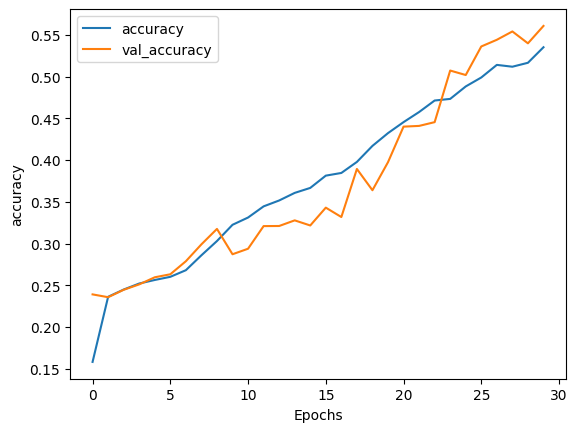

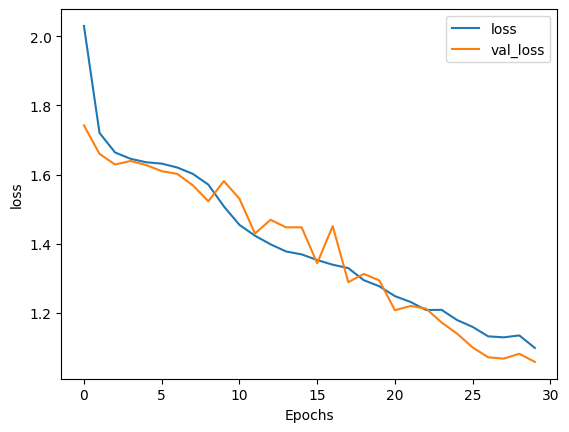

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**If your model passes the previously mentioned thresholds be sure to save your notebook and submit for grading before jumping onto the next section.**

## Optional Exercise - Visualizing 3D Vectors

As you saw on the lecture you can visualize the vectors associated with each word in the training set in a 3D space.

For this run the following cells and visit [Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [ ]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


***Expected Output:***

```
Weights of embedding layer have shape: (1000, 16) 

The above is true if global variables are not modified. 
Notice that this shape will always be (NUM_WORDS, EMBEDDING_DIM).

```

Now run the following cell to generate the `vecs.tsv` and `meta.tsv` files that you will upload to the embedding projector.

In [ ]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Before downloading these files be sure to having already submitted your assignment.


By running the previous cell, these files are placed within your filesystem. To download them, click on the `Jupyter` logo on the upper-left side of the screen. This will take you to the Jupyter filesystem and there you can download the files by selecting them and clicking on the `Download` button.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of classifying text and also learned about embeddings and tokenization along the way!

**Keep it up!**

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center">
</details>